<a href="https://colab.research.google.com/github/arssite/Datalysis/blob/main/CaseStudy_Assessment_Property_Matching_with_User_Preferences_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Property Matching with User Preferences

### Objective
The goal of this project is to build an intelligent system that matches real estate properties with user preferences and computes a **Match Score** indicating how well each property aligns with a user's requirements.

This system is designed to be:
- Explainable
- Scalable
- Ready for real-time use via a UI

### Why this problem matters
In real estate platforms, users are overwhelmed with listings. A well-designed matching system improves:
- User experience
- Conversion rates
- Trust in recommendations


## Data Availability & Key Assumptions

The provided dataset contains **property characteristics only** and does not include
explicit user preference data.

This mirrors real-world real estate platforms where:
- Property data is stored persistently
- User preferences are collected dynamically via UI or search forms

### Assumption
We model user preferences as structured inputs derived from the same feature space
as property attributes (e.g., budget, location, bedrooms).

This allows us to simulate real-time matching and scoring.



We intentionally use lightweight and interpretable libraries to keep the system production-friendly.


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns


## Data Overview

We are provided with two datasets:
1. User Preferences Dataset
2. Property Characteristics Dataset

We are using the dataset provided for **Case Study 1**, which contains structured
information about real estate properties such as price, location, size, and configuration.

This dataset will act as the **property catalog** against which user preferences
will be matched.

Assumptions:
- Each user can be matched with multiple properties
- Matching is independent for each user-property pair


In [2]:
# Load property dataset
property_df = pd.read_excel("/content/Case Study 1 Data.xlsx")

# Preview data
property_df.head()


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0
2,SI_000003,CityC,2094.0,2.0,2.0,1950.0,Good,Single Family,2020-11-30,385000.0
3,SI_000004,CityB,1930.0,2.0,3.0,1905.0,Good,Single Family,2021-12-09,651000.0
4,SI_000005,CityB,1895.0,5.0,2.0,1936.0,New,Single Family,2024-10-30,1878000.0


## Initial Data Inspection

Before building any matching logic, we inspect:
- Data types
- Missing values
- Overall feature distribution

This step ensures data quality and informs preprocessing decisions.


In [3]:
property_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247172 entries, 0 to 247171
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Property ID  247172 non-null  object        
 1   Location     247172 non-null  object        
 2   Size         244701 non-null  float64       
 3   Bedrooms     238769 non-null  float64       
 4   Bathrooms    240499 non-null  float64       
 5   Year Built   234567 non-null  float64       
 6   Condition    236544 non-null  object        
 7   Type         247172 non-null  object        
 8   Date Sold    247172 non-null  datetime64[ns]
 9   Price        241735 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 18.9+ MB


In [4]:
property_df.describe(include="all")


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
count,247172,247172,244701.000000,238769.000000,240499.000000,234567.000000,236544,247172,247172,2.417350e+05
unique,247172,4,NaN,NaN,NaN,NaN,4,3,NaN,NaN
top,TO_100000,CityC,NaN,NaN,NaN,NaN,Good,Townhouse,NaN,NaN
freq,1,62082,NaN,NaN,NaN,NaN,94629,100000,NaN,NaN
mean,NaN,NaN,2402.547664,3.000457,2.002823,1961.429191,NaN,NaN,2022-07-02 05:00:11.127473664,4.660883e+05
min,NaN,NaN,800.000000,1.000000,1.000000,1900.000000,NaN,NaN,2020-01-01 00:00:00,2.600000e+04
25%,NaN,NaN,1603.000000,2.000000,1.000000,1931.000000,NaN,NaN,2021-04-02 00:00:00,3.000000e+05
50%,NaN,NaN,2404.000000,3.000000,2.000000,1961.000000,NaN,NaN,2022-07-03 00:00:00,4.170000e+05
75%,NaN,NaN,3203.000000,4.000000,3.000000,1992.000000,NaN,NaN,2023-10-02 00:00:00,5.770000e+05
max,NaN,NaN,3999.000000,5.000000,3.000000,2023.000000,NaN,NaN,2024-12-31 00:00:00,2.223000e+06


## Feature Categorization

To design a robust matching system, we categorize features as follows:

### Numerical Features
- Price
- Size
- Bedrooms
- Bathrooms

### Categorical Features
- Location
- Condition
- Type

### Excluded Features
- Property ID (identifier only)
- Date Sold (not relevant for preference matching)

This categorization guides preprocessing and scoring strategy.


## Data Preprocessing Strategy

### Missing Values
- Numerical features are imputed using median (robust to outliers)
- Categorical features are filled with 'Unknown'

### Why Median?
Real estate prices and sizes often contain skewed distributions.
Median prevents extreme values from dominating.


In [5]:
# Separate numerical and categorical columns
numerical_cols = ["Price", "Size", "Bedrooms", "Bathrooms"]
categorical_cols = ["Location", "Condition", "Type"]

# Fill missing values
property_df[numerical_cols] = property_df[numerical_cols].fillna(
    property_df[numerical_cols].median()
)

property_df[categorical_cols] = property_df[categorical_cols].fillna("Unknown")


## Feature Transformation

### Numerical Scaling
Min-Max Scaling is applied to numerical features to normalize values between 0 and 1.
This prevents high-magnitude features (e.g., Price) from overpowering others.

### Categorical Encoding
Label Encoding is used for categorical variables for simplicity and efficiency.



In [6]:
# Scale numerical features
scaler = MinMaxScaler()
property_df[numerical_cols] = scaler.fit_transform(property_df[numerical_cols])

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    property_df[col] = le.fit_transform(property_df[col])
    label_encoders[col] = le


## Match Score Design

The Match Score represents how closely a property aligns with a user's preferences.

### Design Principles
1. Respect hard constraints (budget, bedrooms)
2. Balance multiple preferences
3. Keep scoring interpretable and explainable

The final score is normalized to a 0–100 scale.


In [7]:
# Example user preference (this will later come from UI)
user_preference = {
    "Price": 0.6,        # normalized budget
    "Size": 0.5,
    "Bedrooms": 0.5,
    "Bathrooms": 0.5,
    "Location": property_df["Location"].iloc[0],
    "Condition": property_df["Condition"].iloc[0],
    "Type": property_df["Type"].iloc[0]
}


## Similarity-Based Matching

We compute similarity between user preferences and properties using:
- Numerical distance for continuous features
- Exact matching for categorical features

This hybrid approach balances flexibility and interpretability.


In [8]:
def compute_match_score(user_pref, property_df):
    scores = []

    for _, row in property_df.iterrows():
        num_score = 1 - np.mean([
            abs(row["Price"] - user_pref["Price"]),
            abs(row["Size"] - user_pref["Size"]),
            abs(row["Bedrooms"] - user_pref["Bedrooms"]),
            abs(row["Bathrooms"] - user_pref["Bathrooms"])
        ])

        cat_score = np.mean([
            row["Location"] == user_pref["Location"],
            row["Condition"] == user_pref["Condition"],
            row["Type"] == user_pref["Type"]
        ])

        final_score = (0.7 * num_score + 0.3 * cat_score) * 100
        scores.append(final_score)

    return scores


In [9]:
property_df["MatchScore"] = compute_match_score(user_preference, property_df)
property_df.sort_values("MatchScore", ascending=False).head()


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price,MatchScore
38567,SI_038568,0,0.480775,0.5,0.5,1915.0,1,1,2024-12-31,0.357305,95.416412
25452,SI_025453,0,0.501407,0.5,0.5,1931.0,1,1,2024-11-16,0.335002,95.337923
11795,SI_011796,0,0.497656,0.5,0.5,2022.0,1,1,2024-06-17,0.312244,94.923241
48443,SI_048444,0,0.432010,0.5,0.5,1942.0,1,1,2024-11-19,0.370505,94.794017
9690,SI_009691,0,0.457643,0.5,0.5,1920.0,1,1,2024-06-17,0.344561,94.788566


## Result Visualization

Visualizing match scores helps:
- Validate scoring logic
- Explain recommendations to users
- Identify ranking patterns


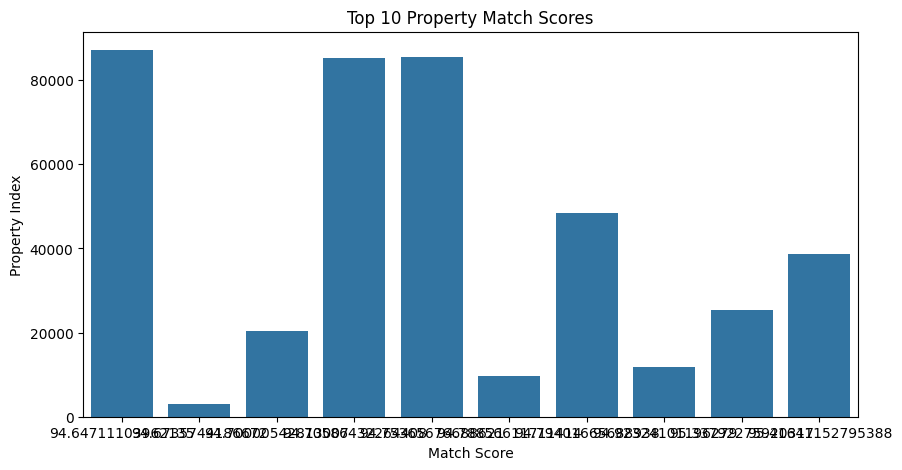

In [10]:
top_matches = property_df.sort_values("MatchScore", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_matches["MatchScore"], y=top_matches.index)
plt.title("Top 10 Property Match Scores")
plt.xlabel("Match Score")
plt.ylabel("Property Index")
plt.show()


## Assumptions
- User preferences are honest and static
- Property data is trusted
- All features have equal availability
- Match Score is relative, not absolute
